# Drivable Area Segmentation

*General structure following [fast.ai notebook on camvid](https://github.com/fastai/course-v3/blob/master/nbs/dl1/lesson3-camvid.ipynb)*

In [1]:
# No need to reload the notebook if any change in the fastai library
%reload_ext autoreload
%autoreload 2

%matplotlib inline
import warnings
warnings.filterwarnings('ignore')


Bad key "text.kerning_factor" on line 4 in
/home/ruslan/.local/lib/python3.6/site-packages/matplotlib/mpl-data/stylelib/_classic_test_patch.mplstyle.
You probably need to get an updated matplotlibrc file from
http://github.com/matplotlib/matplotlib/blob/master/matplotlibrc.template
or from the matplotlib source distribution


In [2]:
from pathlib import Path
import PIL
from tqdm import tqdm
import time

from fastai.vision import *
from fastai.callbacks.hooks import *
from fastai.utils.mem import *
from fastai.callbacks.tracker import SaveModelCallback

# Load Data

### We use the [Berkely Deep Drive Dataset](https://bdd-data.berkeley.edu/) which contains a rich labeled dataset for image segmentation in diverse conditions (weather, city, reference car…).

In [3]:
path_data = Path('/home/ruslan/Desktop/Berkeley_DeepDrive/bdd100k/')
path_lbl = path_data/'drivable_maps'/'labels'
path_img = path_data/'images'/'100k'

### Images and labels filenames

In [4]:
fnames = get_image_files(path_img, recurse = True)
fnames[:3]

[PosixPath('/home/ruslan/Desktop/Berkeley_DeepDrive/bdd100k/images/100k/val/c317c38b-ce5550bb.jpg'),
 PosixPath('/home/ruslan/Desktop/Berkeley_DeepDrive/bdd100k/images/100k/val/b9bd0109-531e640f.jpg'),
 PosixPath('/home/ruslan/Desktop/Berkeley_DeepDrive/bdd100k/images/100k/val/c12b8a48-168db729.jpg')]

In [5]:
lbl_names = get_image_files(path_lbl, recurse = True)
lbl_names[:3]

[PosixPath('/home/ruslan/Desktop/Berkeley_DeepDrive/bdd100k/drivable_maps/labels/val/c389631f-34a8e513_drivable_id.png'),
 PosixPath('/home/ruslan/Desktop/Berkeley_DeepDrive/bdd100k/drivable_maps/labels/val/bf9e5f64-da8a4c40_drivable_id.png'),
 PosixPath('/home/ruslan/Desktop/Berkeley_DeepDrive/bdd100k/drivable_maps/labels/val/bea78bf6-01be38ee_drivable_id.png')]

### Take a look at the image data we have

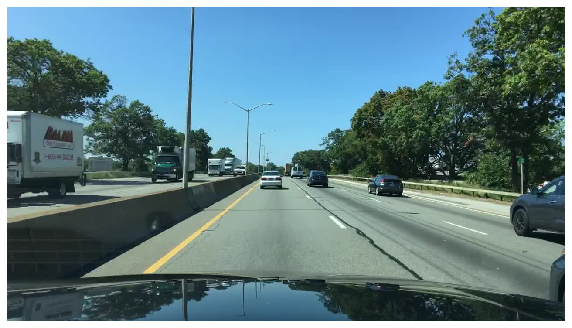

In [6]:
img_f = fnames[100]
img = open_image(img_f)
img.show(figsize=(10,10))

### Now we need to create a function that maps from the path of an image to the path of its segmentation.

In [7]:
get_y_fn = lambda x: path_lbl/x.parts[-2]/f'{x.stem}_drivable_id.png'

img_f, get_y_fn(img_f)

(PosixPath('/home/ruslan/Desktop/Berkeley_DeepDrive/bdd100k/images/100k/val/b7676214-b10e4e0e.jpg'),
 PosixPath('/home/ruslan/Desktop/Berkeley_DeepDrive/bdd100k/drivable_maps/labels/val/b7676214-b10e4e0e_drivable_id.png'))

### We can now use the obtained label path to open a segmentation image.

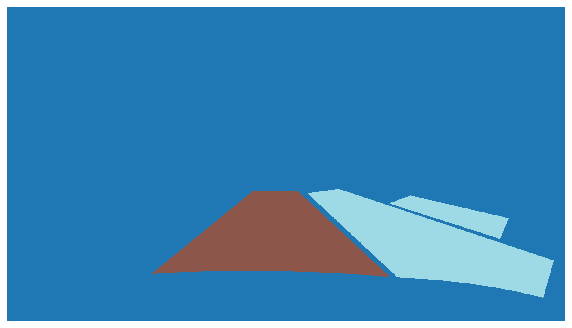

In [8]:
mask = open_mask(get_y_fn(img_f))
mask.show(figsize=(10,10), alpha=1)

In [9]:
src_size = np.array(mask.shape[1:])
src_size, mask.data

(array([ 720, 1280]), tensor([[[0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0],
          ...,
          [0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0]]]))

In [10]:
np.unique(mask.data)

array([0, 1, 2])

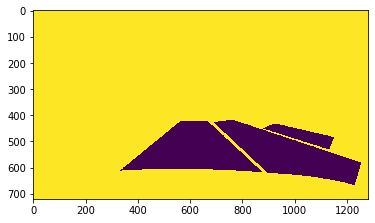

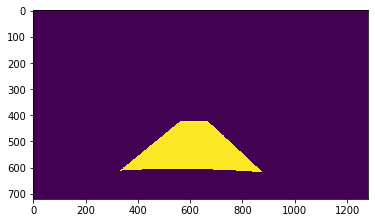

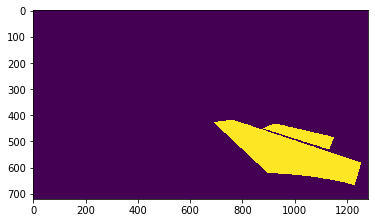

In [11]:
for label in np.unique(mask.data):
    plt.figure()
    plt.imshow(mask.data[0]==label)
plt.show()

# Datasets

Now that we know how our data looks like we can create our data-set using the SegmentationItemList class provided by FastAI.

In [12]:
# size = src_size//4
# bs = 32

size = src_size//2
bs = 8

In [13]:
# Classes extracted from dataset source code
# -> https://github.com/ucbdrive/bdd-data/blob/master/bdd_data/label.py

segmentation_classes = [
    'background', 'current', 'neighbour'
]

In [14]:
src = (SegmentationItemList.from_folder(path_img) # Load in x data from folder
       .split_by_folder(train='train', valid='val') # Split data into training and validation set
       .label_from_func(get_y_fn, classes = segmentation_classes) # Label data using the get_y_fn function
       )

In [15]:
src

LabelLists;

Train: LabelList (70000 items)
x: SegmentationItemList
Image (3, 720, 1280),Image (3, 720, 1280),Image (3, 720, 1280),Image (3, 720, 1280),Image (3, 720, 1280)
y: SegmentationLabelList
ImageSegment (1, 720, 1280),ImageSegment (1, 720, 1280),ImageSegment (1, 720, 1280),ImageSegment (1, 720, 1280),ImageSegment (1, 720, 1280)
Path: /home/ruslan/Desktop/Berkeley_DeepDrive/bdd100k/images/100k;

Valid: LabelList (10000 items)
x: SegmentationItemList
Image (3, 720, 1280),Image (3, 720, 1280),Image (3, 720, 1280),Image (3, 720, 1280),Image (3, 720, 1280)
y: SegmentationLabelList
ImageSegment (1, 720, 1280),ImageSegment (1, 720, 1280),ImageSegment (1, 720, 1280),ImageSegment (1, 720, 1280),ImageSegment (1, 720, 1280)
Path: /home/ruslan/Desktop/Berkeley_DeepDrive/bdd100k/images/100k;

Test: None

In [16]:
src.train.y.loss_func

FlattenedLoss of CrossEntropyLoss()

### Perform data augmentation and create databunch

In [17]:
# Define transformations to apply 
import numpy as np

train_tfms = [
        brightness(change=(0.1, 0.9), p=0.5),
        rotate(degrees=(-20,20), p=0.5),
        contrast(scale=(0.5, 2.), p=0.5),
        jitter(magnitude=np.random.uniform(-0.05, 0.05), p=0.1),
        symmetric_warp(magnitude=(-0.2,0.2), p=0.5),
        zoom(scale=np.random.uniform(1,1.6), p=0.5)
]

valid_tfms = []
# valid_tfms = train_tfms

# transformations = [train_tfms, valid_tfms]
transformations = get_transforms()

data = (src.transform(transformations, size=size, tfm_y=True)
        .databunch(bs=bs) # Create a databunch
        .normalize(imagenet_stats)) # Normalize for resnet

### We can show a few examples using the show_batch method which is available for all sorts of databunches

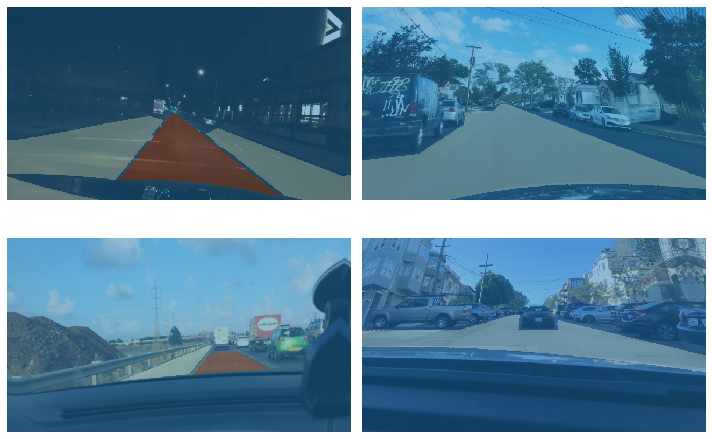

In [18]:
data.show_batch(2, figsize=(10,7))
# data.show_batch(2, figsize=(10,7), ds_type=DatasetType.Valid)

It is also possible to create annotated segmenatation data from scratch by youe own, using such tools as:
https://github.com/abreheret/PixelAnnotationTool

## Model creation and training

A function that will measure the accuracy of the model. The accuracy in an image segmentation problem is the same as that in any classification problem.

Accuracy = no of correctly classified pixels / total pixels

In [33]:
iou = partial(dice, iou=True)
f_score = partial(fbeta, thresh=0.2)
# metrics=[accuracy, iou, f_score]
metrics=[]

wd=1e-6 # weight decay

To create a U-NET in FastAI the unet_learner class can be used. We not only going to pass it our data but we will also specify an encoder-network (Resnet34 in our case), our accuracy function as well as a weight-decay

In [20]:
learn = unet_learner(data, models.resnet34, metrics=metrics, wd=wd).to_fp16()

With our model ready to go we can now search for a fitting learning rate and then start training our model

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


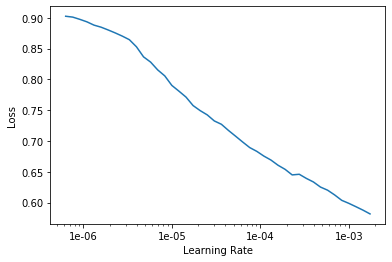

In [21]:
lr_find(learn)
learn.recorder.plot()

To read about picking a learning rate, go to:
https://towardsdatascience.com/fastai-image-classification-32d626da20
We need to select a point on the graph with the fastest decrease in the loss.

In [16]:
lr=5e-5 # pick a learning rate

In [ ]:
# learn.fit_one_cycle(5, slice(lr), pct_start=0.9)

learn.fit_one_cycle(10, slice(lr),
                    callbacks=[SaveModelCallback(learn, name='best_model', every='epoch', monitor='accuracy')])#, pct_start=0.9) # train model

Standardly only the decoder is unfrozen, which means that our pretrained encoder didn’t receive any training yet so we will now show some results and then train the whole model.

In [20]:
import os
current_path = os.getcwd()
# learn.save(current_path + '/trained_models/unet-resnet34-drivable-area-berkeley-1') # save model
# learn.save('unet-resnet34-drivable-area-berkeley')
# learn.show_results(rows=3, figsize=(20,10))

### Perform fine-tuning of all layers

In [24]:
learn.load(current_path + '/trained_models/unet-resnet34-drivable-area-berkeley-1');

In [ ]:
lr_find(learn)
learn.recorder.plot()

In [25]:
learn.unfreeze() # unfreeze all layers

In [26]:
lrs = slice(lr/400,lr/10)

In [27]:
# train the model
learn.fit_one_cycle(5, lrs)

epoch,train_loss,valid_loss,time
0,0.121524,0.113635,1:22:34
1,0.119175,0.111001,1:22:48
2,0.114843,0.109232,1:22:50
3,0.110851,0.107569,1:22:50
4,0.112985,0.107325,1:22:28


In [28]:
learn.save(current_path + '/trained_models/unet-resnet34-drivable-area-berkeley-2', return_path=True)
# learn.save('berkeley-full-size')

PosixPath('/home/ruslan/Desktop/SelfDrivingCar/robot_scene_understanding/Drivable_Area/trained_models/unet-resnet34-drivable-area-berkeley-2.pth')

In [29]:
print(learn.summary())

DynamicUnet
Layer (type)         Output Shape         Param #    Trainable 
Conv2d               [64, 180, 320]       9,408      True      
______________________________________________________________________
BatchNorm2d          [64, 180, 320]       128        True      
______________________________________________________________________
ReLU                 [64, 180, 320]       0          False     
______________________________________________________________________
MaxPool2d            [64, 90, 160]        0          False     
______________________________________________________________________
Conv2d               [64, 90, 160]        36,864     True      
______________________________________________________________________
BatchNorm2d          [64, 90, 160]        128        True      
______________________________________________________________________
ReLU                 [64, 90, 160]        0          False     
__________________________________________________

# Transfer learning

In [ ]:
learn.destroy()

size = src_size

free = gpu_mem_get_free_no_cache()
# the max size of bs depends on the available GPU RAM
bs = 32
print(f"using bs={bs}, have {free}MB of GPU RAM free")

In [ ]:
data = (src.transform(transformations, size=size, tfm_y=True)
        .databunch(bs=bs) # Create a databunch
        .normalize(imagenet_stats)) # Normalize for resnet

In [ ]:
learn = unet_learner(data, models.resnet34, metrics=metrics, wd=wd).to_fp16()

In [19]:
import os
current_path = os.getcwd()

learn.load(current_path + '/trained_models/unet-resnet34-drivable-area-berkeley-2');

In [ ]:
lr_find(learn)
learn.recorder.plot()

In [ ]:
lr = 1e-4

In [ ]:
learn.fit_one_cycle(10, slice(lr), pct_start=0.8)

In [ ]:
learn.save(current_path + '/trained_models/unet-resnet34-drivable-area-berkeley-3')

## Model evaluation on validation dataset

In [18]:
# Training and testing databunch creation
# data_test = (SegmentationItemList.from_folder(path_lbl/'val'))
import os
current_path = os.getcwd()

learn = unet_learner(data, models.resnet34).to_fp16()
learn.load(current_path + '/trained_models/unet-resnet34-drivable-area-berkeley-2');
# learn.load('unet-resnet34-drivable-area-berkeley');

In [19]:
val_lbl_names = get_image_files(path_lbl/'val', recurse = True)

In [252]:
predictions = []
for lbl in tqdm( val_lbl_names[:] ):
    fname = str(lbl)[-30:]
    val_img = open_image(lbl)
    pred_img = learn.predict(val_img)
    predictions.append(pred_img)
    # pred_img[0].save('/home/ruslan/Desktop/drivable_area_results/'+fname)

100%|██████████| 10000/10000 [08:07<00:00, 20.51it/s]


Intersection over Union (IoU)

In [262]:
from sklearn.metrics import confusion_matrix  
import numpy as np

def compute_iou(y_pred, y_true, labels=[0,1,2]):
    y_pred = np.array(y_pred)
    y_true = np.array(y_true)
    # ytrue, ypred is a flatten vector
    y_pred = y_pred.flatten()
    y_true = y_true.flatten()
    current = confusion_matrix(y_true, y_pred, labels=labels)
    # compute mean iou
    intersection = np.diag(current)
    ground_truth_set = current.sum(axis=1)
    predicted_set = current.sum(axis=0)
    union = ground_truth_set + predicted_set - intersection
    IoU = (intersection + 1e-8) / ( union.astype(np.float32) + 1e-8 )

    return np.mean(IoU)

In [247]:
A = np.random.uniform(size=(5,5)) > 0.5
B = np.random.uniform(size=(5,5)) < 0.5

compute_iou(A,B, labels=[0,1])

0.4687500005902778

In [ ]:
Y_pred = predictions[:]
Y = src.valid.y[:]

IoUs = []
for y_true, y_pred in zip(tqdm(Y), Y_pred):
    y = np.array(y_true.data[0])
    y.resize(size)
    y_hat = np.array(y_pred[1][0])
    iou = compute_iou(y, y_hat, labels=[0,1,2])
    IoUs.append(iou)
print('Mean IoU for entire validation dataset: {}'.format(np.mean(IoUs)))

 31%|███▏      | 3137/10000 [04:45<10:22, 11.03it/s]

In [40]:
# Doesn't work due to CPU memory alocation problem
# preds, y = learn.get_preds()
# # get accuracy
# acc = accuracy(preds, y)
# print('The accuracy is {0} %.'.format(acc))

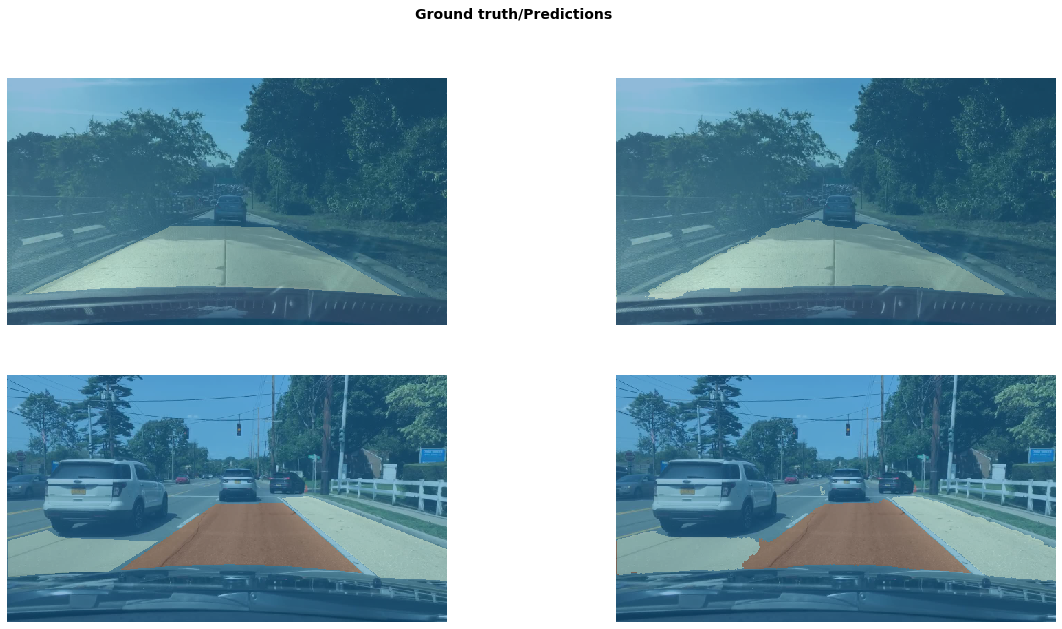

In [21]:
learn.show_results(rows=2, figsize=(20,10))

## Making predictions

In [24]:
learn = unet_learner(data, models.resnet34).to_fp16()
learn.load(current_path + '/trained_models/unet-resnet34-drivable-area-berkeley-2');

### Image inference

In [30]:
def image_inference(filepath):
    test_img = open_image(filepath)

    start = time.time()
    output = learn.predict( test_img )
    print('Inference took %.4f [sec]'%(time.time()-start))

    print('Original shape:', test_img.shape)
    test_resized = test_img.apply_tfms(None, size=output[0].shape)
    # print('Resized shape:', test_resized.shape)

    test_resized.show(figsize=(8,8), y=output[0])

Inference took 0.0766 [sec]
Original shape: torch.Size([3, 1024, 2048])
Inference took 0.0480 [sec]
Original shape: torch.Size([3, 512, 1024])
Inference took 0.0479 [sec]
Original shape: torch.Size([3, 159, 318])
Inference took 0.0600 [sec]
Original shape: torch.Size([3, 800, 1600])


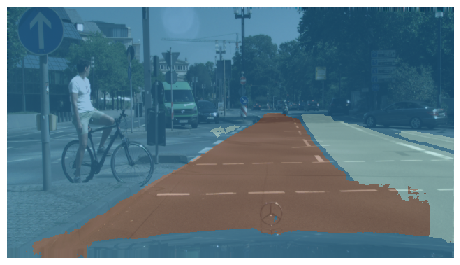

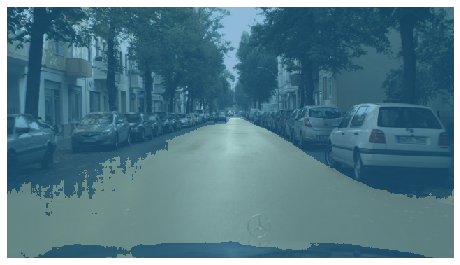

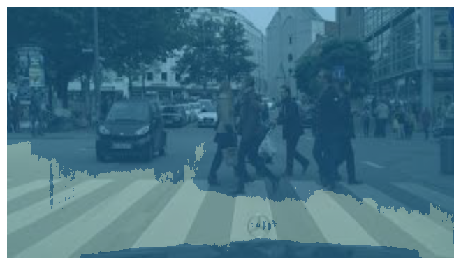

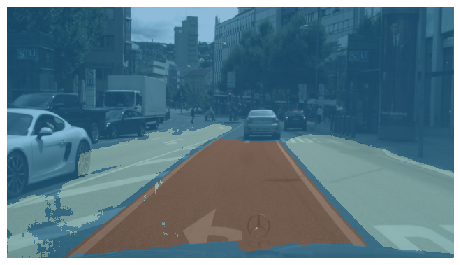

In [31]:
imgs_path = '/home/ruslan/Desktop/example_images/'
images = ['example_01.png', 'example_02.jpg', 'example_03.jpg', 'example_04.png']

for img in images:
    image_inference(imgs_path + img)

### Video inference

In [26]:
def np_img2fastai_img(np_img):
    img_fastai = Image(pil2tensor(np_img, dtype=np.float32).div_(255))
    return img_fastai

In [44]:
import imutils
import cv2
from tqdm import tqdm

vs = cv2.VideoCapture('/home/ruslan/Desktop/example_images/moscow_streets.mp4')
writer = None

# try to determine the total number of frames in the video file
try:
    prop =  cv2.cv.CV_CAP_PROP_FRAME_COUNT if imutils.is_cv2() \
        else cv2.CAP_PROP_FRAME_COUNT
    total = int(vs.get(prop))
    print("[INFO] {} total frames in video".format(total))
# an error occurred while trying to determine the total
# number of frames in the video file
except:
    print("[INFO] could not determine # of frames in video")
    total = -1

# COLORS = open("unet-colors.txt").read().strip().split("\n")
# COLORS = [np.array(c.split(",")).astype("int") for c in COLORS]
# COLORS = np.array(COLORS, dtype="uint8")

np.random.seed(4)
COLORS = np.random.randint(0, 255, size=(len(segmentation_classes) - 1, 3), dtype="uint8")
COLORS = np.vstack([[0, 0, 0], COLORS]).astype("uint8")

FPS = []
while(1):
# for i in tqdm( range(100) ):
    # get raw frames from video stream
    ret, frame = vs.read()
    if ret == False:
        break
    # preprocess raw frames
    start = time.time()
    frame_fastai = np_img2fastai_img(frame)
    output = learn.predict( frame_fastai )
    end = time.time()
    FPS.append(1./(end-start))
#     print("[INFO] single frame took {:.4f} seconds".format(end-start))
    
    # check if the video writer is None
    if writer is None:
        # initialize our video writer
        fourcc = cv2.VideoWriter_fourcc(*"MJPG")
        writer = cv2.VideoWriter('moscow_drivable_berkeley.avi', fourcc, 30,
            (size[1], size[0]), True)

        # some information on processing single frame
        if total > 0:
            elap = (end - start)
            print("[INFO] single frame took {:.4f} seconds".format(elap))
            print("[INFO] estimated total time: {:.4f} [min]".format(elap * total/60.))

    # preprocess output frames before writing to disk
    classMap = np.array(output[1][0], dtype=np.uint8)
    mask = COLORS[classMap]
    frame_resized = cv2.resize(frame, (size[1], size[0]), interpolation = cv2.INTER_AREA)
    output_to_write = (0.6 * frame_resized + 0.4 * mask).astype("uint8")
    # write the output frame to disk
    writer.write(output_to_write)
print("[INFO] Mean FPS {:.4f} Hz".format(np.mean(FPS[1:])))


[INFO] 12911 total frames in video
[INFO] single frame took 0.0446 seconds
[INFO] estimated total time: 9.5966 [min]
[INFO] Mean FPS 25.9806 Hz


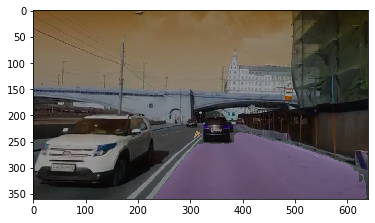

In [45]:
import matplotlib.pyplot as plt
plt.imshow(output_to_write)